In [86]:
#!pip install git+https://github.com/hyperopt/hyperopt-sklearn.git
import wave
import numpy as np
import scipy.io as sio
import scipy.io.wavfile
import matplotlib.pyplot as plt
import librosa
import sklearn
from sklearn.preprocessing import StandardScaler
from scipy.fftpack import dct

# 01 음성파일 raw -> wav 파일 변환

In [87]:
# train_ctl 파일 읽어온 뒤 리스트에 담기
file_path = 'fmcc_train.ctl'
with open(file_path) as f:
    lines = f.readlines()

# 파일명을 담은 리스트를 기준으로 raw -> wav파일로 변환
train_files_names = [i.strip("\n") for i in lines] # \n값 제거
for i in train_files_names:
    with open("raw16k/train/{0}.raw".format(i), "rb") as inp_f:
        data = inp_f.read()
        with wave.open("raw16k/train/{0}.wav".format(i), "wb") as out_f:
            out_f.setnchannels(1) # 바이트 순서 Little Endian, 채널: 1 모노
            out_f.setsampwidth(2) # number of bytes (16bit = 2byte)
            out_f.setframerate(16000)
            out_f.writeframesraw(data)

In [88]:
audio, sr = librosa.load('raw16k/train/FCJY0/FCJY0_pbw1001.wav', sr=16000)
print('sr:', sr, ', audio shape:', audio.shape)
print('length:', audio.shape[0]/float(sr), 'secs')

sr: 16000 , audio shape: (15360,)
length: 0.96 secs


In [89]:
# mfcc로 특징 추출
mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
# mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

In [90]:
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

/opt/homebrew/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [48]:
sample_rate, signal = scipy.io.wavfile.read('raw16k/train/FCJY0/FCJY0_pbw1001.wav')

In [49]:
sample_rate

16000

<function matplotlib.pyplot.show(close=None, block=None)>

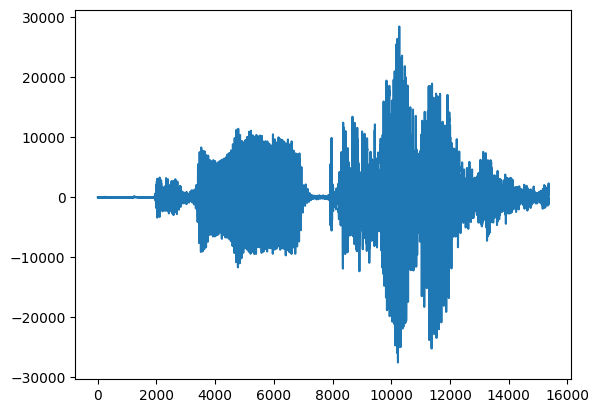

In [50]:
signal
plt.plot(signal)
plt.show

In [51]:
len(signal)

15360

In [52]:
# sample_rate는 원시 음성 신호를 1초에 몇 번 샘플했는지 나타내는 지표
# signal 변수 길이를 sample_rate로 나누면 입력 음성이 몇 초짜리인지 확인 가능
audio_length = len(signal) / sample_rate
audio_length

0.96

In [11]:
# y: 파형의 amplitude 값
# sr: sampling rate

# audio_path = 'raw16k/train/FCJY0/FCJY0_pbw1193.wav'
# y, sr = librosa.load(audio_path)

In [12]:
# 고주파 성분의 에너지 올려주기(모음 발음시 영향이 큼)
# 수식 : y_t=x_t−αx_t−1 (a = pre_emphasis)
pre_emphasis = 0.97 # 주로 0.95 or 0.97 사용
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
emphasized_signal

array([ 6396.  , -2483.12,  2602.63, ...,  1010.87,  -141.36,  -218.02])

In [13]:
# 음성 신호를 짧은 시간 단위로 잘게 쪼개는 과정 -> framing
frame_size = 0.025
frame_stride = 0.01  #  일정 구간(frame_stride=10ms)은 겹치도록 함
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length)) # round : 반올림
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [14]:
print("pad_signal = ", pad_signal)
print(len(pad_signal))
print("indices = ", indices)  # 오디오에서 프레임별 겹칠 인덱스 배열 선언
print("indices.shape = ", indices.shape)
print("frames = ", frames)  # 겹쳐진 프레임 배열 (음성을 25ms단위로 자른 뒤 10ms단위로 겹치게 프레임 처리)
print("frames.shape = ", frames.shape)

pad_signal =  [ 6396.   -2483.12  2602.63 ...     0.       0.       0.  ]
26000
indices =  [[    0     1     2 ...   397   398   399]
 [  160   161   162 ...   557   558   559]
 [  320   321   322 ...   717   718   719]
 ...
 [25120 25121 25122 ... 25517 25518 25519]
 [25280 25281 25282 ... 25677 25678 25679]
 [25440 25441 25442 ... 25837 25838 25839]]
indices.shape =  (160, 400)
frames =  [[ 6396.   -2483.12  2602.63 ...  2343.71  3672.56  3677.03]
 [-5245.01 -4364.31  9554.5  ... -5387.66  1810.52  4827.41]
 [ 1572.12  2051.81  2761.43 ...    49.66  -810.92   193.76]
 ...
 [ -297.02  -292.08 -2067.72 ...  1720.7   -814.51    95.61]
 [ -700.07  1318.   -1964.73 ...  1936.7    114.86  -136.5 ]
 [  183.97   156.43  -408.01 ... -1813.26  2097.46  -483.9 ]]
frames.shape =  (160, 400)


# Windowing

# 해밍윈도우 함수를 이용하여 프레임의 경계를 스무딩

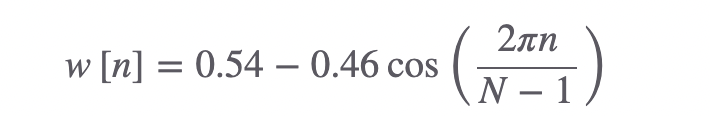

In [15]:
frames *= np.array([0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1)) for n in range(frame_length)])

In [18]:
print(frames)
frames.shape

[[ 511.68       -198.79122193  208.80411539 ...  188.03145022
   294.01426029  294.1624    ]
 [-419.6008     -349.39371347  766.53958514 ... -432.24184011
   144.94486095  386.1928    ]
 [ 125.7696      164.26182266  221.54434105 ...    3.9841285
   -64.9198499    15.5008    ]
 ...
 [ -23.7616      -23.38305845 -165.88929101 ...  138.04852835
   -65.20725465    7.6488    ]
 [ -56.0056      105.51517063 -157.6265968  ...  155.37780256
     9.19535091  -10.92      ]
 [  14.7176       12.52332181  -32.73387578 ... -145.47444326
   167.91642625  -38.712     ]]


(160, 400)

In [24]:
# 각 프레임을 푸리에 변환하기
NFFT = 512   # 주파수 도메인으로 변환할 때 몇 개의 구간로 분석할 것인지 결정, 일반적으로 256 or 512 사용
dft_frames = np.fft.rfft(frames, NFFT)
dft_frames

array([[  395.66309468+0.00000000e+00j,   -55.92668852-3.06599224e+00j,
        -2324.12053119+2.22759913e+03j, ...,
         1192.269781  +2.25498818e+02j,   804.53978696-2.01208996e+02j,
          185.06278349+0.00000000e+00j],
       [ -438.85165564+0.00000000e+00j,   553.16027991-7.38685721e+02j,
        -2053.66917105+2.59435612e+03j, ...,
          524.74989365+6.26291066e+01j,  -550.59379656+1.18199937e+02j,
          614.87828982+0.00000000e+00j],
       [  341.94775425+0.00000000e+00j,  -547.64191653-3.94477584e+02j,
         -153.28909236+4.24028643e+03j, ...,
         -243.07235864-2.20770965e+02j,  -274.49946501+5.42796428e+02j,
         1064.71470356+0.00000000e+00j],
       ...,
       [   20.63464448+0.00000000e+00j,   541.81397407+2.96466012e+02j,
         1206.0321614 -3.81621058e+03j, ...,
          273.70435694-5.50700680e+02j,  -694.95948802+4.31633274e+02j,
          748.93565684+0.00000000e+00j],
       [ -120.35157333+0.00000000e+00j,   339.35816268+1.09436187e+0

In [25]:
print(dft_frames.shape)

(160, 257)


In [26]:
# Magnitude
# MFCC를 구할 때는 음성 인식에 불필요한 위상 정보는 없애고 진폭 정보만을 남김
mag_frames = np.absolute(dft_frames)
mag_frames

array([[ 395.66309468,   56.01066682, 3219.27540506, ..., 1213.40716479,
         829.31859299,  185.06278349],
       [ 438.85165564,  922.84499734, 3308.81258972, ...,  528.47408251,
         563.138308  ,  614.87828982],
       [ 341.94775425,  674.92535375, 4243.05627938, ...,  328.36563537,
         608.25810205, 1064.71470356],
       ...,
       [  20.63464448,  617.62001161, 4002.24646037, ...,  614.96773415,
         818.09288778,  748.93565684],
       [ 120.35157333, 1145.77129548, 4721.34202201, ...,  233.63122817,
         147.84176565,   65.32294218],
       [ 142.90793941, 1084.08763378, 5352.11808157, ...,  249.57394294,
          95.76235036,  155.34702212]])

In [28]:
# Power Spectrum
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
pow_frames

array([[3.05760321e+02, 6.12733359e+00, 2.02416682e+04, ...,
        2.87569716e+03, 1.34329947e+03, 6.68910817e+01],
       [3.76153859e+02, 1.66336502e+03, 2.13832827e+04, ...,
        5.45478234e+02, 6.19384285e+02, 7.38428342e+02],
       [2.28375521e+02, 8.89695768e+02, 3.51631379e+04, ...,
        2.10593731e+02, 7.22613122e+02, 2.21409648e+03],
       ...,
       [8.31618267e-01, 7.45028279e+02, 3.12851108e+04, ...,
        7.38643191e+02, 1.30717963e+03, 1.09551683e+03],
       [2.82900414e+01, 2.56404660e+03, 4.35372470e+04, ...,
        1.06608498e+02, 4.26898197e+01, 8.33415386e+00],
       [3.98880452e+01, 2.29540234e+03, 5.59475937e+04, ...,
        1.21654596e+02, 1.79109917e+01, 4.71341744e+01]])

사람의 소리 인식은 1000Hz 이하의 저주파수(low frequency) 영역대가 고주파수(high frequency) 대비 민감하다고 합니다. 이에 주파수 영역대별 에너지 정보가 있는 데이터(pow_frames)에서 저주파수 영역대를 고주파수 영역대 대비 상대적으로 세밀하게 볼 필요가 있습니다. 이때 적용하는 기법을 필터뱅크(Filter Banks)라고 합니다.

In [29]:
# Filter Banks
# 멜 스케일(Mel Scale) 필터 사용
nfilt = 40  # mel 스케일 필터 갯수
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

In [34]:
# 헤르츠 기준 저주파수 영역대를 세밀하게 살피는 필터
len(fbank[0])
fbank[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
# 고주파수 영역대를 넓게 보는 필터
len(fbank[39])
fbank[39]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<function matplotlib.pyplot.show(close=None, block=None)>

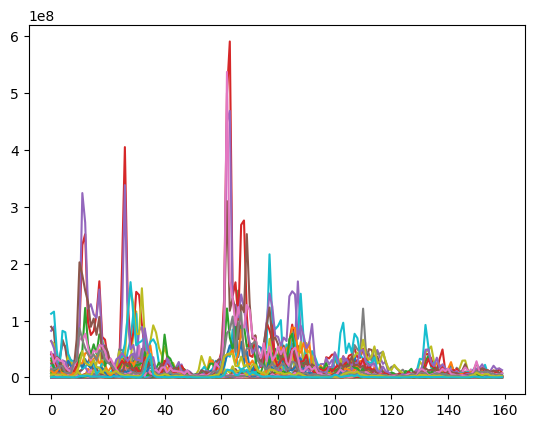

In [37]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
plt.plot(filter_banks)
plt.show

In [38]:
filter_banks = 20 * np.log10(filter_banks)  # dB
filter_banks

array([[ 15.7454305 ,  90.93993421,  96.39294   , ..., 143.19336224,
        134.82376508, 109.48418126],
       [ 64.41975127,  96.44730904, 100.74651526, ..., 143.01443437,
        134.37269439, 120.83179976],
       [ 58.98483049,  96.51708361,  96.44184637, ..., 144.29785298,
        134.47538315, 111.31566999],
       ...,
       [ 57.44345515,  96.48251993,  93.68216918, ..., 132.60171979,
        125.29166749, 103.14703735],
       [ 68.17851829,  98.57559828,  95.12157925, ..., 135.30852726,
        129.79052135, 112.26903604],
       [ 67.2171764 , 100.61914081, 100.11463185, ..., 132.68102719,
        126.41809752, 111.74477054]])

In [39]:
filter_banks.shape

(160, 40)

In [42]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
mfcc

array([[-107.53255124,  -54.9641914 ,    1.90521285, ...,  -20.38041883,
          -1.52058058,  -22.67937537],
       [ -92.94689185,  -49.55998054,   -2.32203134, ...,   -7.81883712,
           5.84890451,  -11.12896632],
       [ -78.78129494,  -38.72882748,   -8.3546162 , ...,  -20.35042714,
           4.00715981,  -16.10102423],
       ...,
       [ -88.92220278,  -29.09954332,   -1.56849433, ...,   -6.38011519,
           7.25903189,  -22.13277191],
       [ -89.46354979,  -25.99594945,  -17.72961735, ...,    3.01138584,
          10.8852849 ,   -5.98793314],
       [ -82.93085136,  -32.75821561,  -14.73836834, ...,  -11.73567915,
           9.20396077,  -13.92822877]])

In [43]:
mfcc.shape

(160, 12)

In [44]:
(nframes, ncoeff) = mfcc.shape
cep_lifter = 22
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

In [45]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [46]:
filter_banks

array([[-49.02434208,  -4.7604982 ,  -9.49226297, ...,   4.61265432,
          3.10629934,  -8.93395655],
       [ -0.35002131,   0.74687662,  -5.13868772, ...,   4.43372644,
          2.65522865,   2.41366195],
       [ -5.78494209,   0.81665119,  -9.4433566 , ...,   5.71714506,
          2.75791741,  -7.10246782],
       ...,
       [ -7.32631743,   0.78208751, -12.2030338 , ...,  -5.97898814,
         -6.42579825, -15.27110046],
       [  3.40874571,   2.87516586, -10.76362373, ...,  -3.27218066,
         -1.92694439,  -6.14910177],
       [  2.44740382,   4.91870839,  -5.77057112, ...,  -5.89968073,
         -5.29936822,  -6.67336726]])